## Question 1

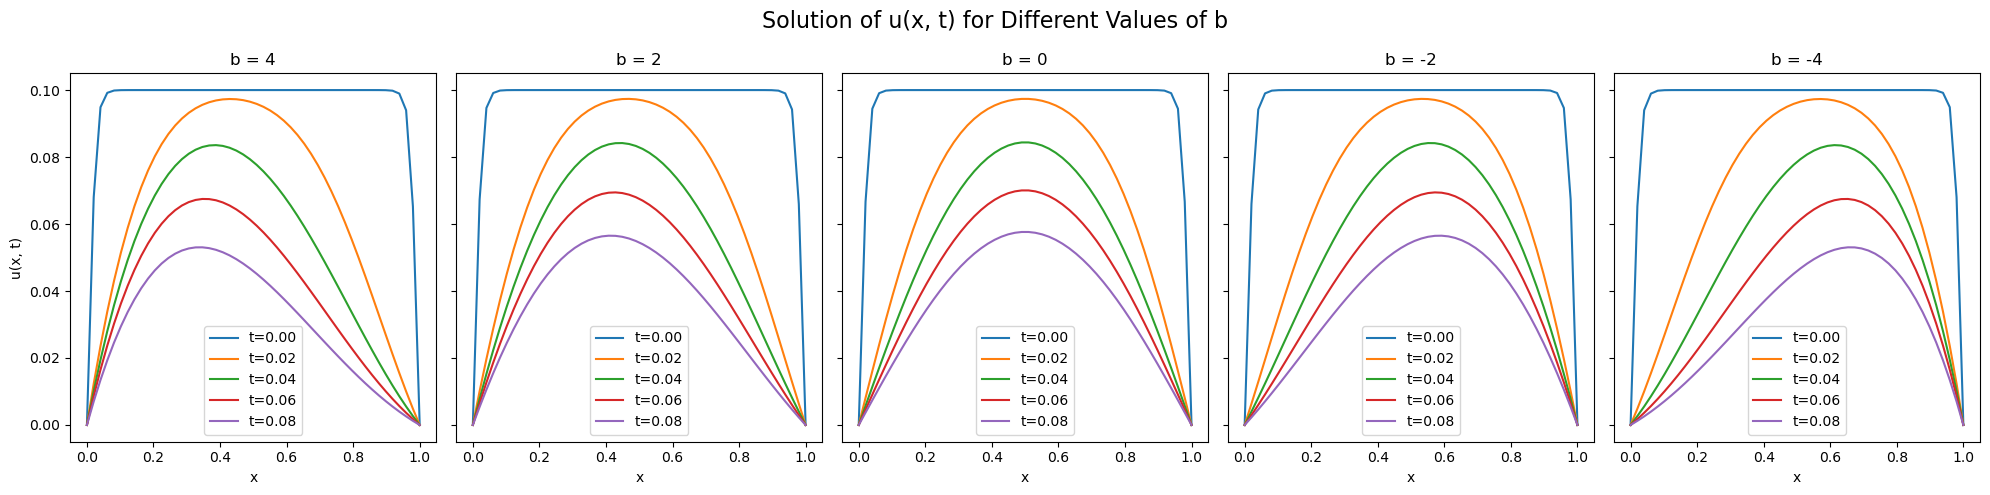

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_elimination_pivot(A, b):
    """
    Solve system of linear equations Ax = b using Gaussian elimination with pivoting
    """
    n = len(A)
    # Create augmented matrix with copies to avoid modifying originals
    M = [[A[i][j] for j in range(n)] for i in range(n)]
    x = [b[i] for i in range(n)]
    
    # Forward elimination with pivoting
    for k in range(n-1):
        # Find pivot
        pivot_index = k
        pivot_value = abs(M[k][k])
        for i in range(k+1, n):
            if abs(M[i][k]) > pivot_value:
                pivot_value = abs(M[i][k])
                pivot_index = i
        
        # Swap rows if better pivot found
        if pivot_index != k:
            M[k], M[pivot_index] = M[pivot_index], M[k]
            x[k], x[pivot_index] = x[pivot_index], x[k]
            
        # Eliminate column k
        for i in range(k+1, n):
            factor = M[i][k] / M[k][k]
            x[i] -= factor * x[k]
            for j in range(k, n):
                M[i][j] -= factor * M[k][j]
    
    # Back substitution
    for k in range(n-1, -1, -1):
        for j in range(k+1, n):
            x[k] -= M[k][j] * x[j]
        x[k] /= M[k][k]
    
    return x

def solve_system(A, B, u):
    """
    Solve the system A * u_new = B * u using Gaussian elimination
    """
    n = len(u) - 2  # Size of internal points (excluding boundaries)
    
    # Extract the tridiagonal part we need to solve (internal points)
    A_internal = [[A[i+1][j+1] for j in range(n)] for i in range(n)]
    
    # Calculate right-hand side vector B * u
    b = np.dot(B[1:n+1, 1:n+1], u[1:n+1])
    
    # Solve using Gaussian elimination
    solution = gaussian_elimination_pivot(A_internal, b)
    
    # Create full solution vector including boundary points
    u_new = np.zeros(len(u))
    u_new[1:n+1] = solution
    return u_new

# Parameters
L = 1.0  # Length of the rod
T = 0.1  # Final time
Nx = 50  # Number of spatial points
Nt = 500  # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt
x = np.linspace(0, L, Nx)
alpha = 1  # Thermal diffusivity

# List of b values to solve for
b_values = [4, 2, 0, -2, -4]

def crank_nicolson_coeff(Nx, dx, dt, b, alpha=1):
    """
    Create Crank-Nicolson coefficient matrices
    """
    r = alpha * dt / (2 * dx**2)
    q = b * dt / (4 * dx)
    
    A = np.zeros((Nx, Nx))  # Left-hand side matrix
    B = np.zeros((Nx, Nx))  # Right-hand side matrix
    
    for i in range(1, Nx-1):
        # Crank-Nicolson for matrix A
        A[i, i-1] = -r + q
        A[i, i] = 1 + 2*r
        A[i, i+1] = -r - q
        
        # Crank-Nicolson for matrix B
        B[i, i-1] = r - q
        B[i, i] = 1 - 2*r
        B[i, i+1] = r + q
    
    # Boundary conditions u(0,t) = u(1,t) = 0
    A[0, 0] = A[Nx-1, Nx-1] = 0
    B[0, 0] = B[Nx-1, Nx-1] = 0
    
    return A, B

def solve_crank_nicolson(b):
    """
    Solve using Crank-Nicolson method for a given b value
    """
    A, B = crank_nicolson_coeff(Nx, dx, dt, b)
    
    # Initial condition: u(x, 0) = 1 for all x
    u = np.full(Nx, .1)
    u_new = np.zeros(Nx)

    # To store solutions for heatmap (space x time)
    u_solutions = np.zeros((Nt, Nx))

    # Time-stepping loop
    for n in range(Nt):
        # Solve the system using our custom Gaussian elimination
        u_new = solve_system(A, B, u)
        u = u_new.copy()
        
        # Store the solution for the heatmap
        u_solutions[n, :] = u
        
    return u_solutions

# Solve for each b value and plot the results
fig, axes = plt.subplots(1, len(b_values), figsize=(20, 5), sharey=True)

for idx, b in enumerate(b_values):
    u_solutions = solve_crank_nicolson(b)

    # Plot specific time steps
    for t_idx in range(0, Nt, Nt // 5):
        axes[idx].plot(x, u_solutions[t_idx, :], label=f't={t_idx*dt:.2f}')
    
    axes[idx].set_title(f'b = {b}')
    axes[idx].set_xlabel('x')
    if idx == 0:
        axes[idx].set_ylabel('u(x, t)')
    axes[idx].legend()

plt.suptitle("Solution of u(x, t) for Different Values of b", fontsize=16)
plt.tight_layout()
plt.show()

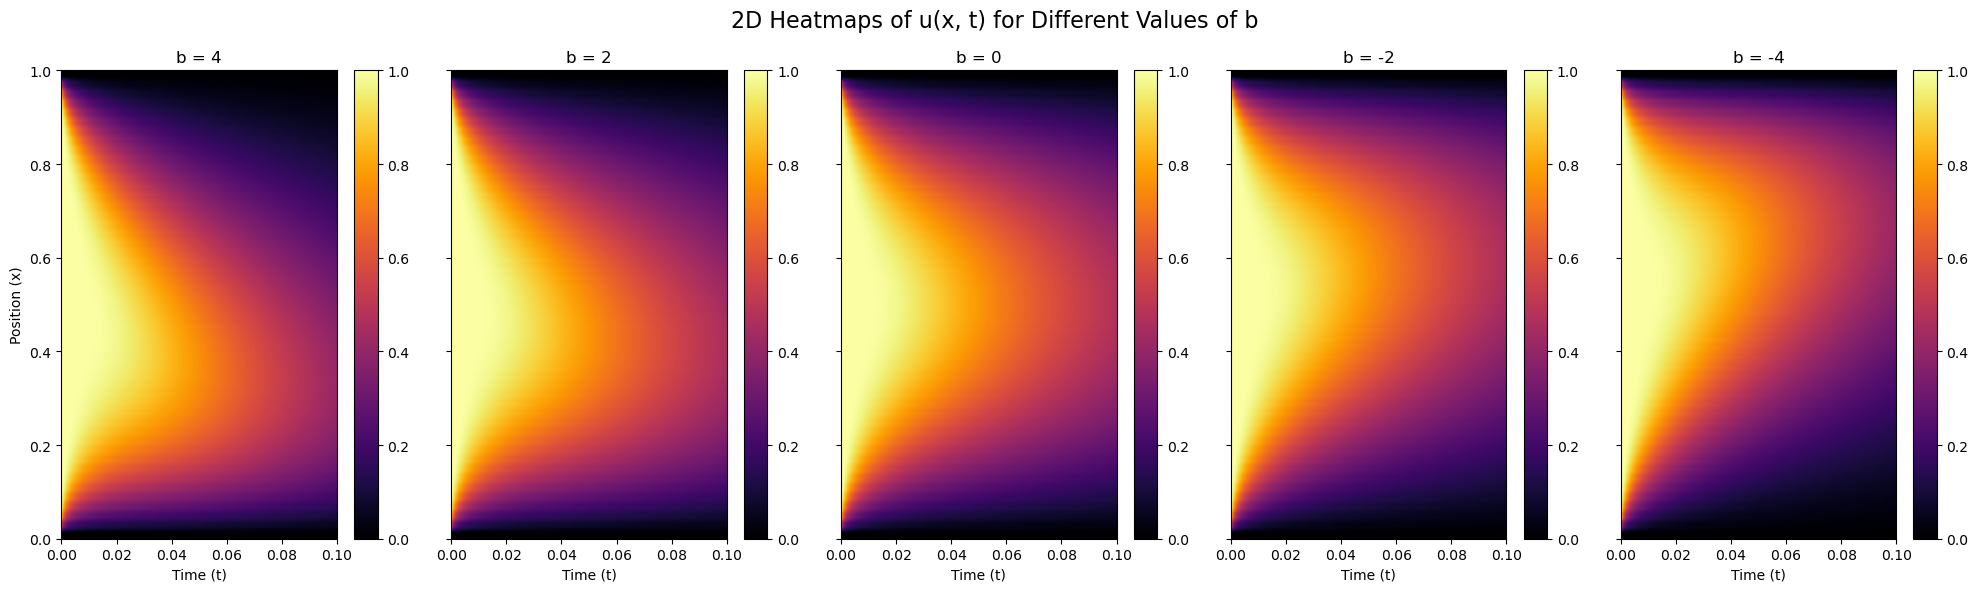

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0  # Length of the rod
T = 0.1  # Final time
Nx = 50  # Number of spatial points
Nt = 500  # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt
x = np.linspace(0, L, Nx)
alpha = 1  # Thermal diffusivity (set to 1 for simplicity)

# List of b values to solve for
b_values = [4, 2, 0, -2, -4]


# Plot 5 heatmaps, one for each b value
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=True)

for idx, b in enumerate(b_values):
    u_heatmap_solutions = solve_crank_nicolson(b)

    # Create a 2D heatmap (space x time) for u(x, t)
    cax = axes[idx].imshow(u_heatmap_solutions.T, extent=[0, T, 0, L], aspect='auto', origin='lower', cmap='inferno')
    
    axes[idx].set_title(f'b = {b}')
    axes[idx].set_xlabel('Time (t)')
    if idx == 0:
        axes[idx].set_ylabel('Position (x)')
    
    # Add a color bar to each subplot
    fig.colorbar(cax, ax=axes[idx])

plt.suptitle("2D Heatmaps of u(x, t) for Different Values of b", fontsize=16)
plt.tight_layout()
plt.show()


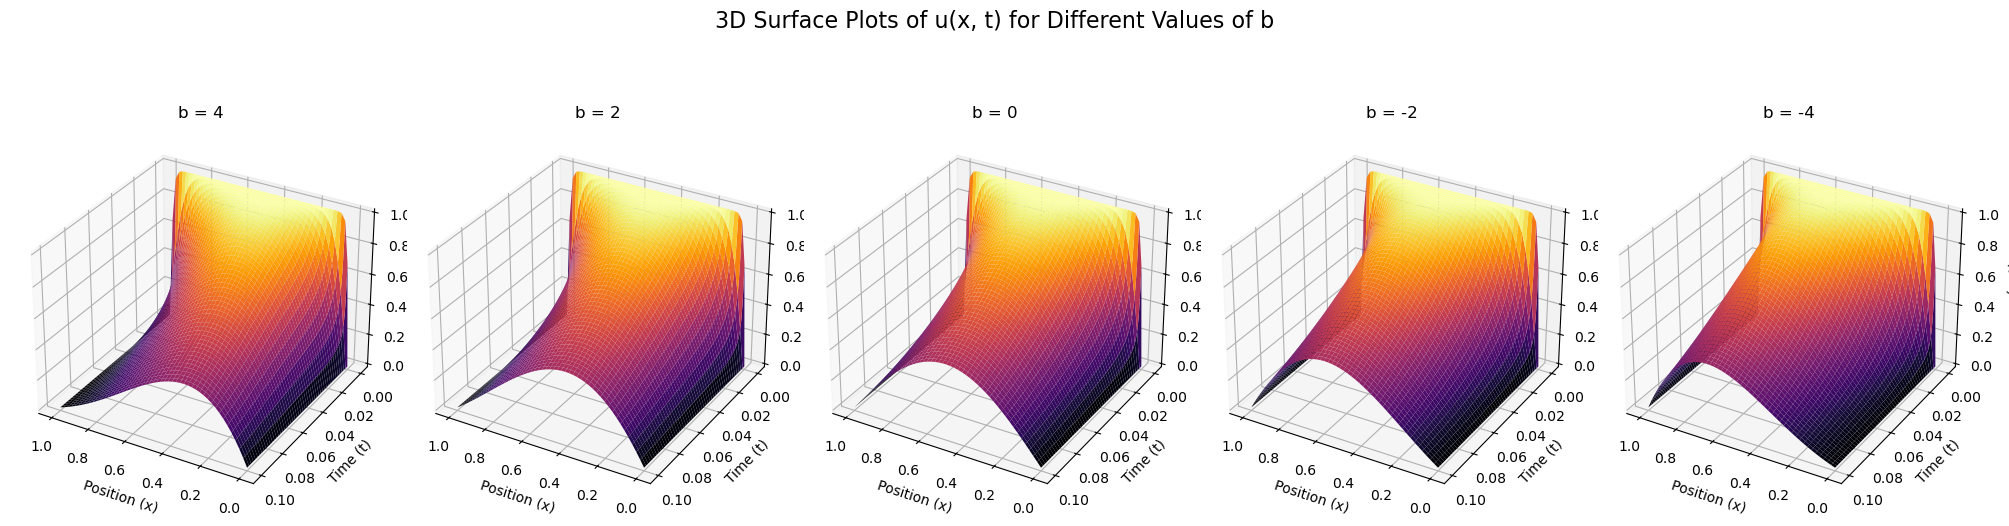

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
L = 1.0  # Length of the rod
T = 0.1  # Final time
Nx = 50  # Number of spatial points
Nt = 500  # Number of time steps
dx = L / (Nx - 1)
dt = T / Nt
x = np.linspace(0, L, Nx)
time = np.linspace(0, T, Nt)
alpha = 1  # Thermal diffusivity

# List of b values to solve for
b_values = [4, 2, 0, -2, -4]

# 3D plot setup
fig = plt.figure(figsize=(20, 6))

for idx, b in enumerate(b_values):
    ax = fig.add_subplot(1, 5, idx + 1, projection='3d')
    
    # Get the solution for current b
    u_solutions = solve_crank_nicolson(b)
    
    # Create a meshgrid for x and t
    X, T = np.meshgrid(x, time)
    
    # Plot the surface
    ax.plot_surface(X, T, u_solutions, cmap='inferno', edgecolor='none')
    
    # Labels and title
    ax.set_title(f'b = {b}')
    ax.set_xlabel('Position (x)')
    ax.set_ylabel('Time (t)')
    ax.set_zlabel('u(x, t)')
    ax.view_init(elev=30, azim=120)  # Adjust view angle if needed

plt.suptitle("3D Surface Plots of u(x, t) for Different Values of b", fontsize=16)
plt.tight_layout()
plt.show()


## Question 2

$k = f(c) = \frac{k_{max}c^2}{c_s + c^2}$ 

Now we invert the equation to get a new form as: 

$\frac{1}{k} = \frac{c_s}{k_{max}}\cdot\frac{1}{c^2} + \frac{1}{k_{max}}$

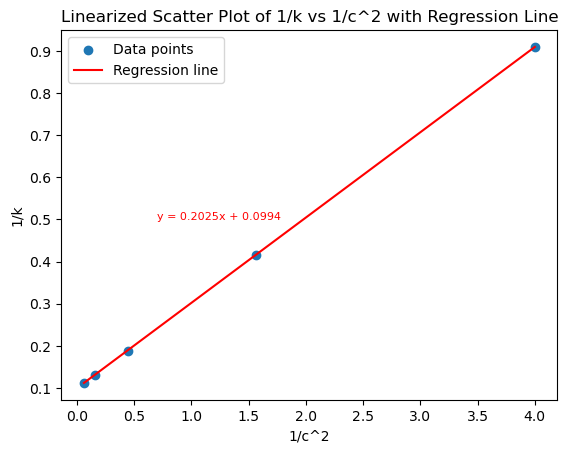

Slope: 0.2025
Intercept: 0.0994


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data
c = np.array([0.5, 0.8, 1.5, 2.5, 4])
k = np.array([1.1, 2.4, 5.3, 7.6, 8.9])

# Transformations: 1/c^2 and 1/k
csq_inv = (1 / c)**2
k_inv = 1 / k

# Calculate the slope (m) and intercept (b) for the transformed variables
n = len(csq_inv)
mean_csq_inv = np.mean(csq_inv)
mean_k_inv = np.mean(k_inv)

numerator = np.sum((csq_inv - mean_csq_inv) * (k_inv - mean_k_inv))
denominator = np.sum((csq_inv - mean_csq_inv)**2)

slope = numerator / denominator
intercept = mean_k_inv - slope * mean_csq_inv

# Regression line for the transformed data
regression_line = slope * csq_inv + intercept

# Plotting
plt.title("Linearized Scatter Plot of 1/k vs 1/c^2 with Regression Line")
plt.xlabel("1/c^2") 
plt.ylabel("1/k") 
plt.scatter(csq_inv, k_inv, label='Data points')
plt.text(0.7, 0.5, f"y = {slope:.4f}x + {intercept:.4f}", fontsize=8, color="red")
plt.plot(csq_inv, regression_line, color='red', label='Regression line')
plt.legend()
plt.show()

# Print calculated slope and intercept
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")


Now $k_{max}$ is just $k_{max} = \frac{1}{intercept} \approx 10.06$
and $c_s = k_{max} * slope =0.2025 * 10.06 = 2.037$

In [6]:
k_max = 1/intercept
c_s = k_max * slope
print(f'Q.2 i.) c_s =  {c_s:.4f} and k_max = {k_max:.4f}')  

Q.2 i.) c_s =  2.0372 and k_max = 10.0607


#### Growth at c = 2 mg/L

In [7]:
k_2 = slope * 1/4 + intercept
k_2 = 1/k_2
print(f'Q.2 ii.) k_2 = {k_2:.4f}')

Q.2 ii.) k_2 = 6.6658
